### Khai báo các thư viện cần thiết

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import itertools
import ast
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

### Đọc vào dữ liệu

In [4]:
data_ner = pd.read_excel(r"data_LSTM.xlsx")
data_ner.dropna()

,Word,NER
0,Đó là con đường biển ngắn nhất để đi từ Ấn_Độ_...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
1,Một chuyến hải_trình xuyên ba nước Malaysia Si...,"['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'B-LOC..."
2,Từ bức điện của IMB,"['O', 'O', 'O', 'O', 'B-ORG']"
3,Chúng_tôi lên_đường ngay khi nhận được email c...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Ông còn nhấn_mạnh trong thư_điện_tử Phải hết_s...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
...,...,...
2044,Theo cơ_quan điều_tra vụ_việc sẽ không bị chìm...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2045,Vì_sao,['O']
2046,Lãnh_đạo Cơ_quan cảnh_sát điều_tra trả_lời vì ...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2047,Bộ_trưởng ra toà làm nhân_chứng,"['O', 'O', 'O', 'O', 'O']"


### In ra kích thước của dữ liệu

In [5]:
print("Số lượng văn bản: ", data_ner.shape[0])

Số lượng văn bản:  2049


### Thông tin cơ bản về dữ liệu

In [6]:
data_ner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Word    2049 non-null   object
 1   NER     2049 non-null   object
dtypes: object(2)
memory usage: 32.1+ KB


### Xử lý dữ liệu cột NER về kiểu list

In [7]:
data_ner['NER'] = data_ner['NER'].apply(ast.literal_eval)

### Thống kê số lượng của mỗi nhãn thực thể

In [8]:
all_values = list(itertools.chain.from_iterable(data_ner['NER']))

In [9]:
np.array(all_values)

array(['O', 'O', 'O', ..., 'I-PER', 'O', 'O'], dtype='<U6')

In [10]:
pd.value_counts(all_values)

O         36619
B-PER       979
B-LOC       720
I-PER       508
I-LOC       374
I-ORG       288
B-ORG       191
I-MISC       28
B-MISC       27
Name: count, dtype: int64

### Mã hóa cột Word

##### Xây dựng từ điển

In [11]:
def process_corpus(corpus):
    
    unique_words = set()
    word_to_id = {}
    current_id = 1
    
    for text in corpus:
        words = text.lower().split()
        for word in words:
            if word not in unique_words:
                unique_words.add(word)
                word_to_id[word] = current_id
                current_id += 1
    
    return unique_words, word_to_id

unique_words, word_to_id = process_corpus(data_ner['Word'])
print(word_to_id)

{'đó': 1, 'là': 2, 'con': 3, 'đường': 4, 'biển': 5, 'ngắn': 6, 'nhất': 7, 'để': 8, 'đi': 9, 'từ': 10, 'ấn_độ_dương': 11, 'sang': 12, 'thái_bình_dương': 13, 'chiếm': 14, 'đến': 15, 'lượng': 16, 'hàng_hoá': 17, 'lưu_thông': 18, 'đường_biển': 19, 'của': 20, 'thế_giới': 21, 'hải_trình': 22, 'lớn': 23, 'tây': 24, 'đông': 25, 'với': 26, '50': 27, 'lượt': 28, 'tàu_bè': 29, 'qua_lại': 30, 'mỗi': 31, 'năm': 32, 'một': 33, 'chuyến': 34, 'xuyên': 35, 'ba': 36, 'nước': 37, 'malaysia': 38, 'singapore': 39, 'indonesia': 40, 'vừa': 41, 'được': 42, 'phóng_viên': 43, 'tuổi_trẻ': 44, 'thực_hiện': 45, 'cảm_nhận': 46, 'điều': 47, 'mà': 48, 'các': 49, 'thuỷ_thủ': 50, 'tàu': 51, 'viễn_dương': 52, 'đã': 53, 'khi': 54, 'nghe': 55, 'nhắc': 56, 'tới': 57, 'hải_tặc': 58, 'eo_biển': 59, 'malacca': 60, 'bức': 61, 'điện': 62, 'imb': 63, 'chúng_tôi': 64, 'lên_đường': 65, 'ngay': 66, 'nhận': 67, 'email': 68, 'ngài': 69, 'noel': 70, 'choong': 71, 'trưởng': 72, 'đại_diện': 73, 'cơ_quan': 74, 'hàng_hải': 75, 'quốc_tế': 

##### Dùng từ điển để mã hóa cho cột Word

In [12]:
def encode_text(text, vocab):
    max_len = 150
    words = text.split()
    encoded_text = [vocab[word.lower()] if word.lower() in vocab else -1 for word in words]
    encoded_text = encoded_text + ([0]*(max_len-np.array(words).shape[0]))
    return encoded_text

X_pre = np.array([encode_text(sentence, word_to_id) for sentence in data_ner['Word']])

##### In ra cột Word sau khi mã hóa

In [13]:
X_pre

array([[   1,    2,    3, ...,    0,    0,    0],
       [  33,   34,   22, ...,    0,    0,    0],
       [  10,   61,   62, ...,    0,    0,    0],
       ...,
       [1310,   74,  273, ...,    0,    0,    0],
       [5055,  171, 3482, ...,    0,    0,    0],
       [ 239, 5055,  708, ...,    0,    0,    0]])

##### Ví dụ văn bản thứ 3 trước khi chưa mã hóa

In [14]:
data_ner['Word'][2]

'Từ bức điện của IMB'

##### Văn bản thứ 3 sau khi được mã hóa

In [15]:
X_pre[2]

array([10, 61, 62, 20, 63,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

### Mã hóa cột NER

##### In ra tập các giá trị phân biệt trong cột NER

In [16]:
pd.unique(all_values)

array(['O', 'B-LOC', 'B-ORG', 'I-LOC', 'B-PER', 'I-PER', 'I-ORG',
       'B-MISC', 'I-MISC'], dtype=object)

##### Xây dựng từ điển

In [17]:
tags2id = {}
for i, tag in enumerate(pd.unique(all_values)):
    tags2id[tag] = i

##### In ra từ điển đã xây dựng

In [18]:
tags2id

{'O': 0,
 'B-LOC': 1,
 'B-ORG': 2,
 'I-LOC': 3,
 'B-PER': 4,
 'I-PER': 5,
 'I-ORG': 6,
 'B-MISC': 7,
 'I-MISC': 8}

##### Xây dựng từ điển ngược dùng để mã hóa về ban đầu

In [19]:
id2tags = {value: key for key, value in tags2id.items()}

##### In ra từ điển ngược

In [20]:
id2tags

{0: 'O',
 1: 'B-LOC',
 2: 'B-ORG',
 3: 'I-LOC',
 4: 'B-PER',
 5: 'I-PER',
 6: 'I-ORG',
 7: 'B-MISC',
 8: 'I-MISC'}

##### Hàm dùng từ điển thuận để mã hóa cho cột NER

In [21]:
def preprocess_tags(tags2id, Y):
    
    Y_pre = []
    max_len = 150
    for y in Y:
        
        Y_place_holder = []
        
        for tag in y:
            Y_place_holder.append(tags2id[tag])
        
        padded_tags = Y_place_holder + ([0] * (max_len - np.array(Y_place_holder).shape[0]))
        Y_pre.append(padded_tags)
        
    return Y_pre

##### Áp dụng hàm trên để mã hóa cho cột NER

In [22]:
Y_pre = preprocess_tags(tags2id, data_ner['NER'])

##### Ví dụ list thứ 3 trước khi chưa mã hóa

In [23]:
np.array(data_ner['NER'][3])

array(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O',
       'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'B-ORG', 'O', 'B-LOC', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC'],
      dtype='<U5')

##### List thứ 3 sau khi mã hóa

In [24]:
np.array(Y_pre[3])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 0, 2, 6, 6, 2, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Chia dữ liệu thành 3 tập Train : Validation : Test theo tỷ lệ 70 : 10 : 20

In [25]:
len = data_ner.shape[0]
X_train = X_pre[:int(len*0.7)]
X_val = X_pre[int(len*0.7):int(len*0.8)]
X_test = X_pre[int(len*0.8):]
Y_train = Y_pre[:int(len*0.7)]
Y_val = Y_pre[int(len*0.7):int(len*0.8)]
Y_test = Y_pre[int(len*0.8):]

##### In ra kích thước tập Train, Validation, Test

In [26]:
print("Số mẫu của data_Train: ", X_train.shape[0])
print("Số mẫu của data_Validation: ", X_val.shape[0])
print("Số mẫu của data_Test: ", X_test.shape[0])

Số mẫu của data_Train:  1434
Số mẫu của data_Validation:  205
Số mẫu của data_Test:  410


### Xây dựng mô hình BiLSTM

##### Đưa dữ liêu Train và Validation về kiểu phừ hợp với mô hình

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

##### Chia dữ liệu Train và Validation thành các batch

In [28]:
BATCH_SIZE = 28
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [29]:
embedding_dim = 200
maxlen = 150
max_words = 20000
num_tags = 9

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dense(num_tags, activation='softmax')
])

c:\Users\84936\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


##### Khởi tạo trình biên dịch

In [30]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam')

##### Thực hiện huấn luyện mô hình

In [31]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=15)

Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 335ms/step - loss: 0.3952 - val_loss: 0.0423
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 329ms/step - loss: 0.0554 - val_loss: 0.0396
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - loss: 0.0508 - val_loss: 0.0361
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - loss: 0.0438 - val_loss: 0.0310
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - loss: 0.0332 - val_loss: 0.0255
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - loss: 0.0234 - val_loss: 0.0259
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - loss: 0.0179 - val_loss: 0.0249
Epoch 8/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 498ms/step - loss: 0.0151 - val_loss: 0.0249
Epoch 9/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 568ms/step - loss: 0.0140 - val_loss: 0.0280
Epoch 10/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 595ms/step - loss: 0.0121 - val_loss: 0.0276
Epoch 11/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 598ms/step - loss: 0.0088 - val_loss: 0.0272
Epoch 12/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 31

### Dự đoán và đánh giá mô hình

##### Viết hàm để dự đoán về lấy nhãn mặc định cho 1 mẫu

In [32]:
data_test = data_ner.iloc[int(len*0.8):]
def make_prediction(model, i, id2tag):
    
    len_orginal_sententce = np.array(data_test['Word'].iloc[i].split()).shape[0]
    
    prediction = model.predict(X_test[i].reshape((1, 150)))
    prediction = np.argmax(prediction[0], axis=1)
    
    prediction = list(prediction)[ : len_orginal_sententce] 
    
    pred_tag_list = []
    for tag_id in prediction:
        pred_tag_list.append(id2tag[tag_id])
    
    return pred_tag_list

### Dự đoán cho 1 mẫu bất kỳ

In [33]:
pred_tag_list = make_prediction(model=model,
                                i = 4,
                                id2tag=id2tags)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


##### Nhãn dự đoán

In [34]:
np.array(pred_tag_list)

array(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O',
       'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O'], dtype='<U5')

##### Nhãn thực tế

In [35]:
np.array(data_test['NER'].iloc[4])

array(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O',
       'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O'], dtype='<U5')

### Lấy ra tập dự đoán

In [36]:
pred_NER = []
for k in range (0, data_test.shape[0]):
    pred_tag_list = make_prediction(model=model,
                                    i = k,
                                    id2tag=id2tags)
    pred_NER.append(pred_tag_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━

##### Đưa mảng pred_NER về dataframe

In [37]:
pred_NER = pd.DataFrame({'pred_NER':pred_NER})

##### In ra 5 dòng đầu tiên của data dự đoán

In [38]:
pred_NER['pred_NER'].head()

0                             [O, O, O, O, O, O, O, O]
1        [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
2                 [O, O, O, O, O, O, O, O, O, O, O, O]
3                          [O, O, O, O, O, O, O, O, O]
4    [O, O, O, O, O, O, O, B-LOC, I-LOC, O, O, O, B...
Name: pred_NER, dtype: object

##### In ra 5 dòng đầu tiên của data thực tế

In [39]:
data_test['NER'].head()

1639                             [O, O, O, O, O, O, O, O]
1640        [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
1641                 [O, O, O, O, O, O, O, O, O, O, O, O]
1642                          [O, O, O, O, O, O, O, O, O]
1643    [O, O, O, O, O, O, O, B-LOC, I-LOC, O, O, O, B...
Name: NER, dtype: object

### In ra các độ đo đánh giá mô hình

In [40]:
true_labels = [item for sublist in data_test['NER'].tolist() for item in sublist]
pred_labels = [item for sublist in pred_NER['pred_NER'].tolist() for item in sublist]

precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
accuracy = accuracy_score(true_labels, pred_labels)

In [41]:
accuracy, precision, recall, f1

(0.9412766924125398,
 0.9289991342249706,
 0.9412766924125398,
 0.9309296810656079)

### Trực quan ma trận nhầm lẫn

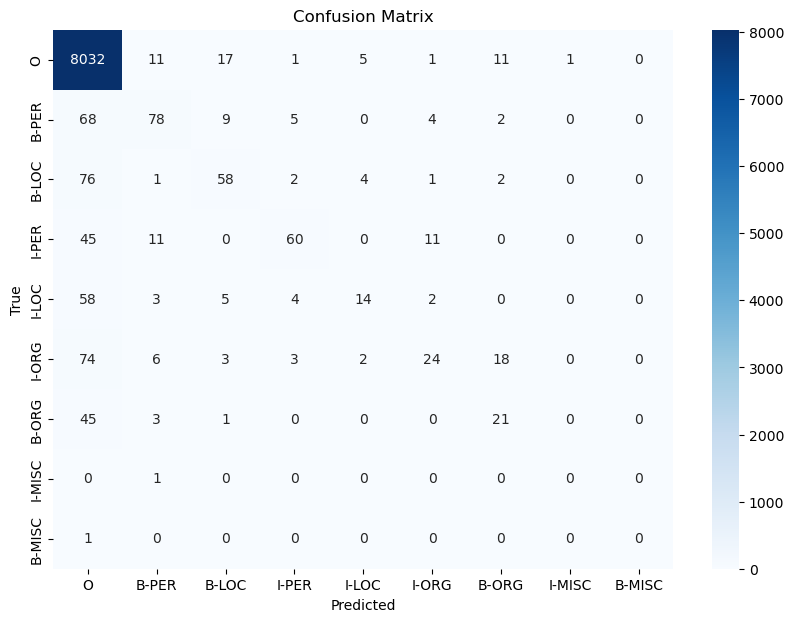

In [42]:
label = ['O', 'B-PER', 'B-LOC', 'I-PER', 'I-LOC', 'I-ORG', 'B-ORG', 'I-MISC', 'B-MISC']

cm = confusion_matrix(true_labels, pred_labels, labels=label)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [43]:
all_values = list(itertools.chain.from_iterable(data_test['NER']))
pd.value_counts(all_values)

O         8079
B-PER      166
B-LOC      144
I-ORG      130
I-PER      127
I-LOC       86
B-ORG       70
B-MISC       1
I-MISC       1
Name: count, dtype: int64

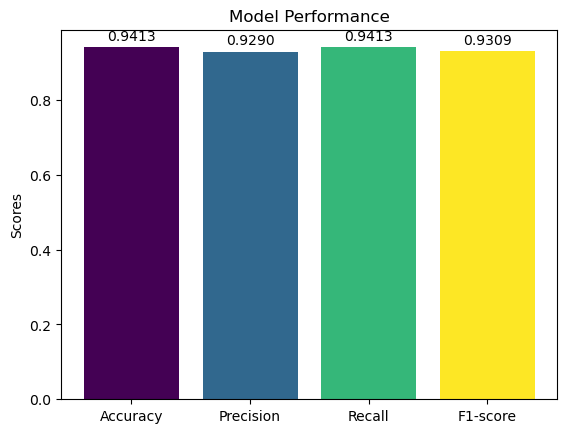

In [44]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

model_scores = [accuracy, precision, recall, f1]

colors = plt.cm.viridis(np.linspace(0, 1, 4))

x = range(4)

fig, ax = plt.subplots()
bars = ax.bar(x, model_scores, color=colors)

ax.set_ylabel('Scores')
ax.set_title('Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars)

plt.show()